# Macroeconomic default modelling - a Machine Learning approach

### PART 2

### Outline of the script(s)
- Creating the Analytic Base Table (ABT) + Exploratory Data Analysis _(0 ABT.ipynb)_


__ Preprocessing the Dataset__  _(This Notebook)_


- Modelling part   _(2a R models.ipynb)_

### 1. First, let's load (and install where neccessary) the packages that we are using

In [108]:
### Load packages (and install the ones missing)
suppressMessages(if (!require("pacman")) install.packages("pacman", repos = "http://cran.us.r-project.org"))
pacman::p_load("readxl","Hmisc","mice",
                                "VIM","car","Amelia","IRdisplay",
                                "ggplot2", "dplyr", "caret", "broom",
                                "tibble","labeling", "digest", "tseries", 
                                "mombf", "robustbase","forecast", "caTools",
                                "mlbench", "party", "psych","Boruta", "astsa",
                                "nortest", "normtest", "e1071", "prophet",
                                "tibble","labeling", "digest", "tseries", 
                                "mombf", "robustbase","forecast", "caTools",
                                "mlbench", "party", "rpart", "e1071", "cluster",
                                "randomForest", "gbm", "xgboost", "h2o", "timetk",
                                "tidyquant", "nnet", "dataPreparation", "imputeTS")#add more packages here if needed! #"imputeTS"
#install_github("SteffenMoritz/imputeTS")#run if needed

### 2. Let's load in our ABT

In [109]:
document_name = "ABT.csv"
file_location=paste(getwd(),"/", document_name, sep= "")

ABT <- read.csv(file_location, stringsAsFactors = FALSE)
ABT <- as.data.frame(ABT)
ABT$Date = as.Date(as.character(ABT$Date), "%Y-%m-%d")

In [110]:
#short inspection
head(ABT,5)

cat("Number of columns of our clean ABT:", ncol(ABT),"\n")
cat("Number of rows of our clean ABT:", nrow(ABT))

Date,pre_34_CRPh_L.Ratings,pre_35_CRPh_A.Ratings,pre_36_CRPh_AR_Z_.1Q.,pre_37_CRPh_AR_N_.1Q.,pre_38_CRPh_AR_.1Q.,pre_39_CRPh_AR_Z_.1J.,pre_40_CRPh_AR_N_.1J.,pre_41_CRPh_AR_.1J.,pre_42_CRPh_PD,...,pre_622_EU_IND_PROD_VOLA,pre_623_D_LABPROD_USD,pre_646_EUR_Gross_Invest,pre_647_GER_Gross_Invest,pre_648_CBOEVIX,pre_651_BBJPY1W,pre_654_BBJPY6M,pre_658_TRJP30T,pre_660_TRJP2YT,pre_662_ESGBOND.
2016-06-30,506,0,0,506.8791,0.000000000,4,506.0685,0.007904068,0.01528634,...,104.6,103.1000,104.1,104.4000,14.77,-0.06200,-0.00950,0.142,-0.298,0.0148
2016-05-31,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,103.9,103.0444,103.5,105.1667,14.20,-0.02557,-0.00507,0.299,-0.236,0.0157
2016-04-30,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,105.3,102.9889,102.9,105.9333,14.68,-0.03414,0.00586,0.346,-0.233,0.0153
2016-03-31,519,1,1,518.2857,0.001929438,3,503.9315,0.005953190,0.01541704,...,103.8,102.9333,102.3,106.7000,13.10,-0.07529,0.02350,0.542,-0.207,0.0154
2016-02-29,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,104.4,102.6000,102.5,106.3000,17.70,-0.05300,-0.00629,0.860,-0.232,0.0172


Number of columns of our clean ABT: 87 
Number of rows of our clean ABT: 106

## Before we proceed any further we must split the dataset into train and test set

- A training dataset is a dataset of examples used for learning, that is to fit the parameters


- A test set is therefore a set of examples used only to assess the performance (i.e. generalization) of a fully specified model.


- In general, to avoid introducing a bias in test using train-data, the train-test split should be performed before (most) data preparation steps.


- To simulate a train and test set we are going to split randomly this data set into __66% train__ and __34% test__

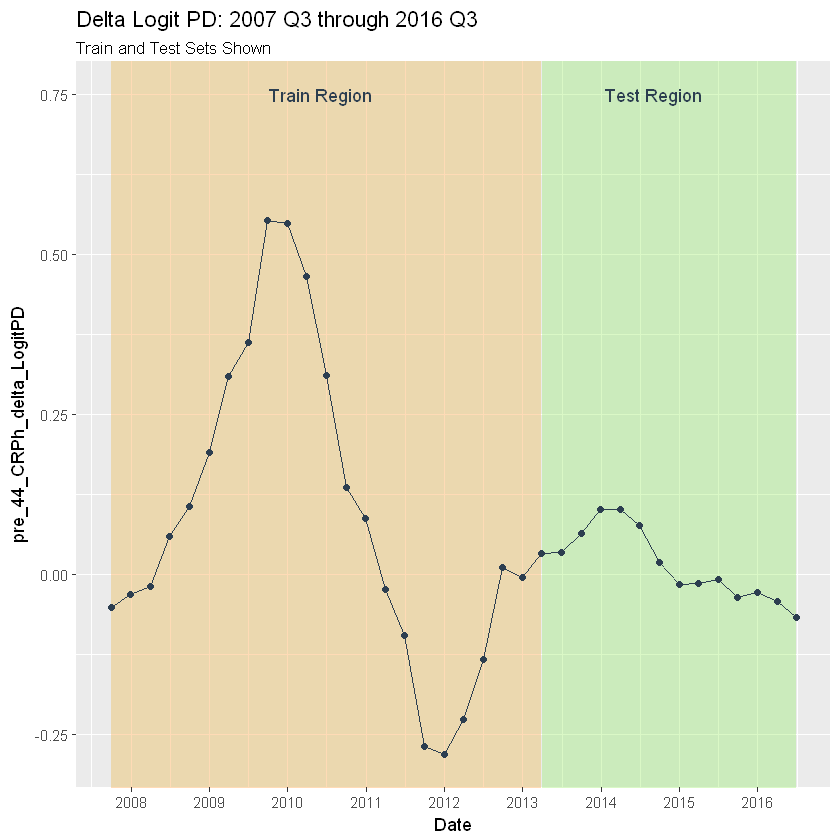

In [111]:
# For Delta-Logit-PD first
ABT %>%
    select(Date, pre_44_CRPh_delta_LogitPD)%>%
    na.omit()%>%
    ggplot(aes(Date, pre_44_CRPh_delta_LogitPD))+
# Train Region
    geom_rect(xmin = as.numeric(ymd("2007-10-01")),
              xmax = as.numeric(ymd("2013-03-31")),
              ymin = -1, ymax = Inf, alpha = 0.02,
             fill = palette_light()[[9]])+
    annotate("text", x = ymd("2010-06-01"), y = 0.75,
             color = palette_light()[[1]], label = "Train Region")+
# Validation Region
   # geom_rect(xmin = as.numeric(ymd("2011-01-01")), 
    #          xmax = as.numeric(ymd("2013-12-31")),
     #         ymin = -1, ymax = Inf, alpha = 0.02,
      #        fill = palette_light()[[3]])+
    #annotate("text", x = ymd("2012-06-01"), y = 0.75,
     #        color = palette_light()[[1]], label = "Validation\n Region")+
# Test Region
    geom_rect(xmin = as.numeric(ymd("2013-04-01")), 
              xmax = as.numeric(ymd("2016-06-30")),
              ymin = -1, ymax = Inf, alpha = 0.02,
              fill = palette_light()[[7]]) +
    annotate("text", x = ymd("2014-08-31"), y = 0.75,
     color = palette_light()[[1]], label = "Test Region") +
# Data
    geom_line(col = palette_light()[1]) +
    geom_point(col = palette_light()[1]) +
    #geom_ma(ma_fun = SMA, n = 4, size = 1) +
# Aesthetics
    #theme_tq() +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Delta Logit PD: 2007 Q3 through 2016 Q3",
         subtitle = "Train and Test Sets Shown") 

### Similarly for Delta-Logit-AR:

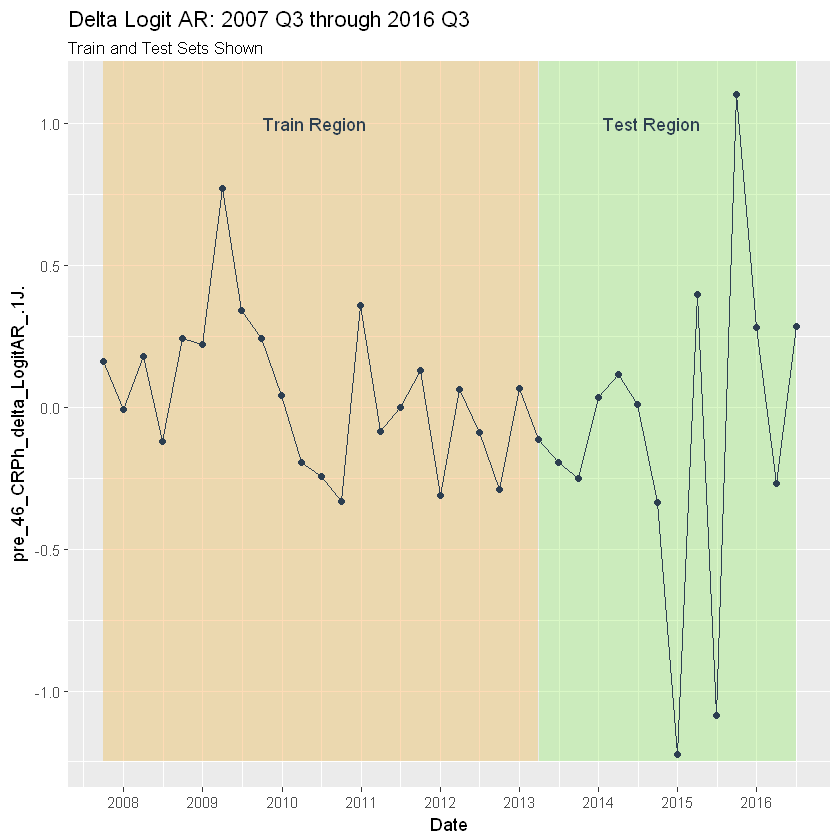

In [112]:
ABT %>%
    select(Date, pre_46_CRPh_delta_LogitAR_.1J.)%>%
    na.omit()%>%
    ggplot(aes(Date, pre_46_CRPh_delta_LogitAR_.1J.))+
# Train Region
    geom_rect(xmin = as.numeric(ymd("2007-10-01")),
              xmax = as.numeric(ymd("2013-03-31")),
              ymin = -1.25, ymax = Inf, alpha = 0.02,
             fill = palette_light()[[9]])+
    annotate("text", x = ymd("2010-06-01"), y = 1,
             color = palette_light()[[1]], label = "Train Region")+
# Validation Region
   # geom_rect(xmin = as.numeric(ymd("2011-01-01")), 
    #          xmax = as.numeric(ymd("2013-12-31")),
     #         ymin = -1, ymax = Inf, alpha = 0.02,
      #        fill = palette_light()[[3]])+
    #annotate("text", x = ymd("2012-06-01"), y = 0.75,
     #        color = palette_light()[[1]], label = "Validation\n Region")+
# Test Region
    geom_rect(xmin = as.numeric(ymd("2013-04-01")), 
              xmax = as.numeric(ymd("2016-06-30")),
              ymin = -1.25, ymax = Inf, alpha = 0.02,
              fill = palette_light()[[7]]) +
    annotate("text", x = ymd("2014-08-31"), y = 1,
     color = palette_light()[[1]], label = "Test Region") +
# Data
    geom_line(col = palette_light()[1]) +
    geom_point(col = palette_light()[1]) +
    #geom_ma(ma_fun = SMA, n = 4, size = 1) +
# Aesthetics
    #theme_tq() +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Delta Logit AR: 2007 Q3 through 2016 Q3",
         subtitle = "Train and Test Sets Shown") 

### 3. Creating our ABT_train and ABT_test datasets

- We chose a cutoff point at 2013-03-31, such that the balance between train and test ist 2:1


- We will do two sets of predicitons:
    - __Delta-Logit-PD__
    - __Delta-Logit-AR__
    
where these two will be the respective target variable in each dataset

In [113]:
cutoff_date = "2013-03-31"

# Build ABT_train, ABT_test
ABT_train <- ABT%>% filter(Date <= cutoff_date)
ABT_test <- ABT%>% filter(Date > cutoff_date)

cat("Number of rows in Train set", nrow(ABT_train), "\n")
cat("Number of rows in Test set", nrow(ABT_test), "\n")

Number of rows in Train set 67 
Number of rows in Test set 39 


In [123]:
# Delta-Logit-PD
X_train_PD <- ABT_train%>%select(-contains("_CRPh_"), -contains("Date"))
y_train_PD <- ABT_train$pre_44_CRPh_delta_LogitPD

X_test_PD <- ABT_test%>%select(-contains("_CRPh_"), -contains("Date"))
y_test_PD <- ABT_test$pre_44_CRPh_delta_LogitPD

# Delta-Logit-AR

X_train_AR <- ABT_train%>%select(-contains("_CRPh_"), -contains("Date"))
y_train_AR <- ABT_train$pre_46_CRPh_delta_LogitAR_.1J.

X_test_AR <- ABT_test%>%select(-contains("_CRPh_"), -contains("Date"))
y_test_AR <- ABT_test$pre_46_CRPh_delta_LogitAR_.1J.

### 4.1 Time Series Missing Value Imputation of Train and Test set

#### Imputation (replacement) of missing values in univariate time series.

__Two options:__

- Univariate time Series interpolation using spline/linear of stine 


- Missing Value Imputation by Kalman Smoothing


- Of course other methods exist (Multiple Imputation using Chained equations), 
    - perhaps more suitable for our case, but harder to implement (also very slow)


__which imputation method do you see to be most applicable to our situation?__


In [124]:
#y_train_PD = na.interpolation(y_test_PD, option = "spline") #linear/stine
y_train_PD = na.kalman(y_train_PD, model = "StructTS", smooth = TRUE, nit = -1)

#y_train_AR = na.interpolation(y_test_PD, option = "spline") #linear/stine
y_train_AR = na.kalman(y_train_AR, model = "StructTS", smooth = TRUE, nit = -1)

#y_test_PD = na.interpolation(y_test_PD, option = "spline") #linear/stine
y_test_PD = na.kalman(y_test_PD, model = "StructTS", smooth = TRUE, nit = -1)

#y_test_AR = na.interpolation(y_test_PD, option = "spline") #linear/stine
y_test_AR = na.kalman(y_test_AR, model = "StructTS", smooth = TRUE, nit = -1)

### 4.2 Alternatively we can take linear and constant interpolation approach (for simplicity)

- Missing Value Imputation by Interpolation (linear)


- Missing Value Imputation by Last Observation Carried Forward (constant interpolation so to speak)

[1] TRUE

[1] TRUE

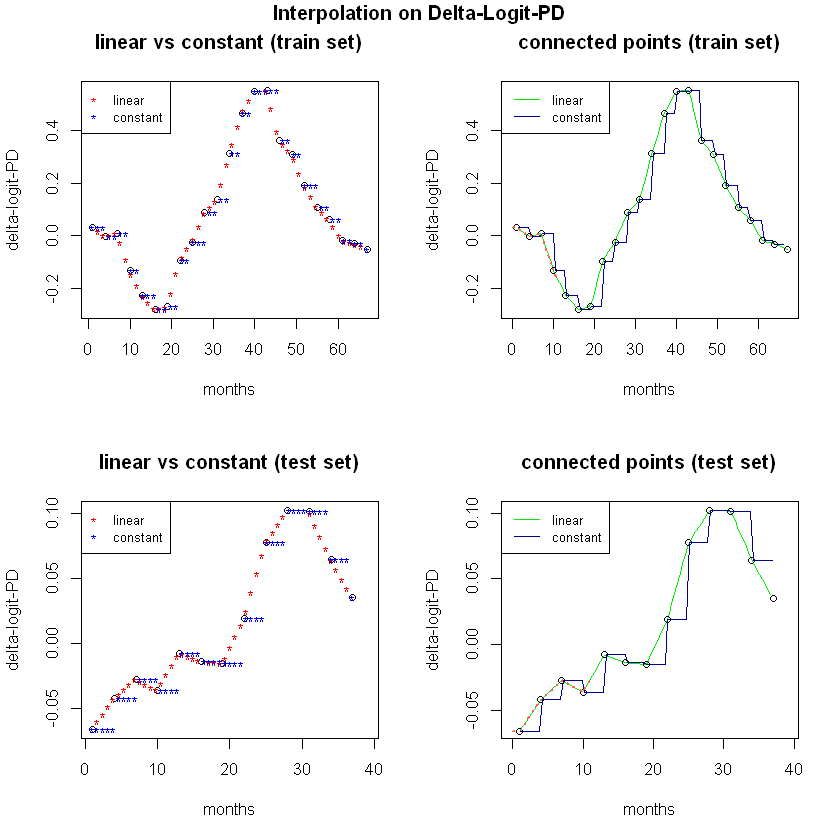

In [126]:
#linear method
par(mfrow = c(2,2))
x_date = ABT_train$Date
x = 1:length(x_date)
y = ABT_train$pre_44_CRPh_delta_LogitPD

#Plot first graph
plot(x, y, main = "linear vs constant (train set)", ylab = "delta-logit-PD", xlab = "months")
points(approx(x, y), col = 2, pch = "*")
points(approx(x, y, method = "constant"), col = 4, pch = "*")
legend(x="topleft", legend=c("linear","constant"), col=c(2,4), lty=c(0,0), pch="*" ,cex=0.8)

f <- approxfun(x, y)

#Plot second graph
curve(f(x), 0, length(x_date), col = "green2", main = "connected points (train set)",
      ylab = "delta-logit-PD", xlab = "months")
points(x, y)
is.function(fc <- approxfun(x, y, method = "const")) # TRUE
curve(fc(x), 0, length(x_date)-1, col = "darkblue", add = TRUE)

## different extrapolation on left and right side :
plot(approxfun(x, y, rule = 2:1), 0, 11,
     col = "tomato", add = TRUE, lty = 3, lwd = 2)
legend("topleft", legend=c("linear", "constant"),
       col=c("green2", "darkblue"), lty=c(1,1), cex=0.8)

################################################################################################################################
x_date = ABT_test$Date
x = 1:length(x_date)
y = ABT_test$pre_44_CRPh_delta_LogitPD

#Plot first graph
plot(x, y, main = "linear vs constant (test set)", ylab = "delta-logit-PD", xlab = "months")
points(approx(x, y), col = 2, pch = "*")
points(approx(x, y, method = "constant"), col = 4, pch = "*")
legend(x="topleft", legend=c("linear","constant"), col=c(2,4), lty=c(0,0), pch="*" ,cex=0.8)

f <- approxfun(x, y)

#Plot second graph
curve(f(x), 0, length(x_date), col = "green2", main = "connected points (test set)",
      ylab = "delta-logit-PD", xlab = "months")
points(x, y)
is.function(fc <- approxfun(x, y, method = "const")) # TRUE
curve(fc(x), 0, length(x_date)-1, col = "darkblue", add = TRUE)

## different extrapolation on left and right side :
plot(approxfun(x, y, rule = 2:1), 0, 11,
     col = "tomato", add = TRUE, lty = 3, lwd = 2)
legend("topleft", legend=c("linear", "constant"),
       col=c("green2", "darkblue"), lty=c(1,1), cex=0.8)

title(main="Interpolation on Delta-Logit-PD", outer = T, line = -1)

[1] TRUE

[1] TRUE

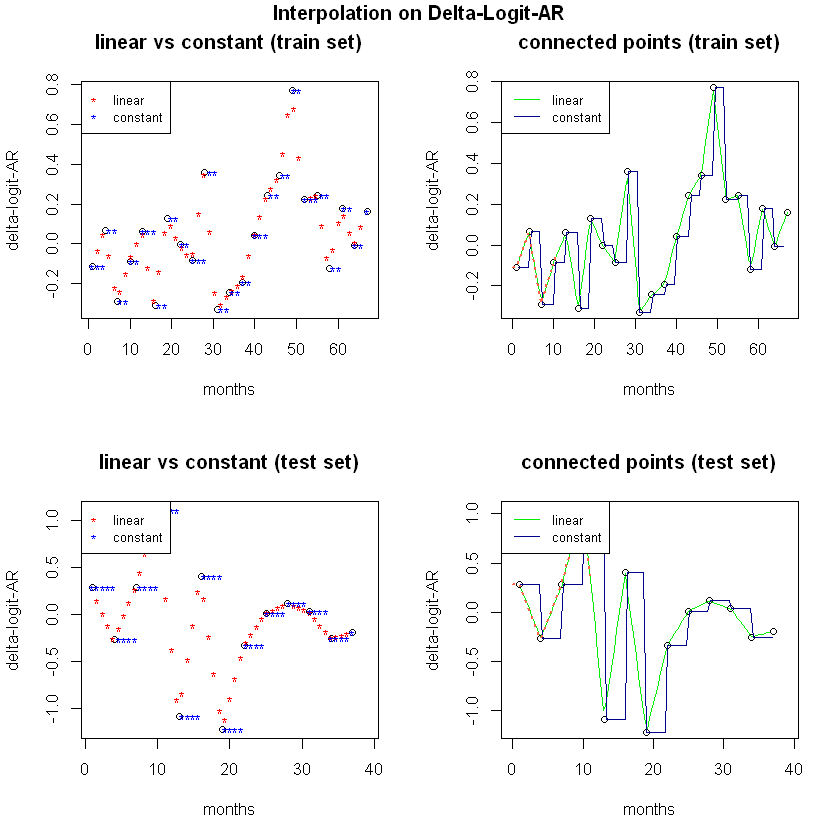

In [127]:
#linear method
par(mfrow = c(2,2))
x_date = ABT_train$Date
x = 1:length(x_date)
y = ABT_train$pre_46_CRPh_delta_LogitAR_.1J.

#Plot first graph
plot(x, y, main = "linear vs constant (train set)", ylab = "delta-logit-AR", xlab = "months")
points(approx(x, y), col = 2, pch = "*")
points(approx(x, y, method = "constant"), col = 4, pch = "*")
legend(x="topleft", legend=c("linear","constant"), col=c(2,4), lty=c(0,0), pch="*" ,cex=0.8)

f <- approxfun(x, y)

#Plot second graph
curve(f(x), 0, length(x_date), col = "green2", main = "connected points (train set)",
      ylab = "delta-logit-AR", xlab = "months")
points(x, y)
is.function(fc <- approxfun(x, y, method = "const")) # TRUE
curve(fc(x), 0, length(x_date)-1, col = "darkblue", add = TRUE)

## different extrapolation on left and right side :
plot(approxfun(x, y, rule = 2:1), 0, 11,
     col = "tomato", add = TRUE, lty = 3, lwd = 2)
legend("topleft", legend=c("linear", "constant"),
       col=c("green2", "darkblue"), lty=c(1,1), cex=0.8)

################################################################################################################################
x_date = ABT_test$Date
x = 1:length(x_date)
y = ABT_test$pre_46_CRPh_delta_LogitAR_.1J.

#Plot first graph
plot(x, y, main = "linear vs constant (test set)", ylab = "delta-logit-AR", xlab = "months")
points(approx(x, y), col = 2, pch = "*")
points(approx(x, y, method = "constant"), col = 4, pch = "*")
legend(x="topleft", legend=c("linear","constant"), col=c(2,4), lty=c(0,0), pch="*" ,cex=0.8)

f <- approxfun(x, y)

#Plot second graph
curve(f(x), 0, length(x_date), col = "green2", main = "connected points (test set)",
      ylab = "delta-logit-AR", xlab = "months")
points(x, y)
is.function(fc <- approxfun(x, y, method = "const")) # TRUE
curve(fc(x), 0, length(x_date)-1, col = "darkblue", add = TRUE)

## different extrapolation on left and right side :
plot(approxfun(x, y, rule = 2:1), 0, 11,
     col = "tomato", add = TRUE, lty = 3, lwd = 2)
legend("topleft", legend=c("linear", "constant"),
       col=c("green2", "darkblue"), lty=c(1,1), cex=0.8)

title(main="Interpolation on Delta-Logit-AR", outer = T, line = -1)

### Conclusion: 

As we can see, the linear/last observation carried forward did not do so well regarding Delta-Logit-AR

As a result we will take the Kalman interpolation

### 5. Principal Component Analysis (PCA)

### What is PCA?

- method of extracting important variables (in form of components) from a large set of variables available in a data set. 


- It extracts low dimensional set of features from a high dimensional data set with a motive to capture as much information as possible. 


- With fewer variables, visualization also becomes much more meaningful.



### The purpose of principal component analysis is to find:


- the best low-dimensional representation of the variation in a multivariate data set


### How is it done and what is the end result

- It is always performed on a symmetric correlation or covariance matrix. This means the matrix should be numeric and have standardized data.


- It is done via linear transformation of the data as well as orthogonal projection


- As a result, all principle components are orthogonal to one another


Let’s say we have a data set of dimension $100 × 50$. I.e  50 predictors. Since we have a large $p = 50$, there can be $\frac{p(p-1)}{2}$ scatter plots i.e more than 1000 plots possible to analyze the variable relationship. Wouldn’t is be a tedious job to perform exploratory analysis on this data ?

In this case, it would be a lucid approach to select a subset of $p$ $ (p << 50)$ predictor which captures as much information.

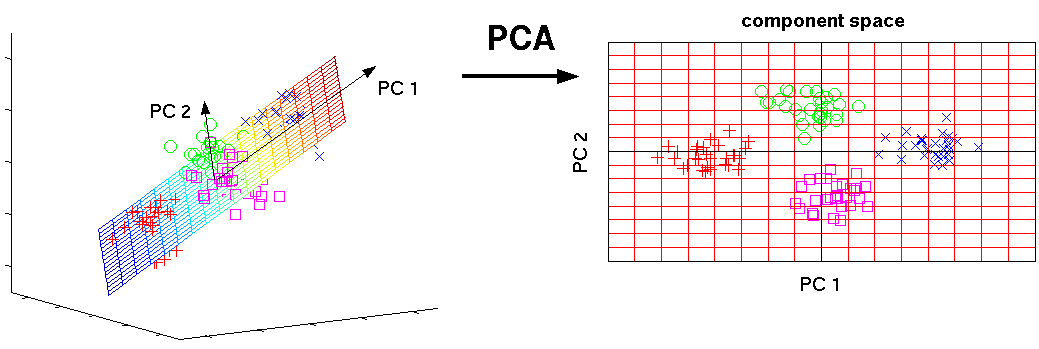

In [128]:
#The image below shows the transformation of a high dimensional data (3 dimension) to low dimensional data (2 dimension)
#using PCA. Not to forget, each resultant dimension is a linear combination of p features

document_name = "PCA_1.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location)  

## What are principal components ?

A principal component is a normalized linear combination of the original predictors in a data set. In image above, PC1 and PC2 are the principal components. Let’s say we have a set of predictors as 

$$X^1, X^2, \ldots, X^p$$

The 1st principal component can be written as:

$$ Z^1 = \theta ^{11}\cdot X^1 + \theta ^{21}\cdot X^2 + \ldots + \theta ^{p1} \cdot X^p$$

where: 

__where,__

- $Z^1$ is first principal component


- $\theta^{p1}$ is the loading vector comprising of loadings $(\theta ^1, \theta ^2 \ldots)$ of the first principal component. 


- The loadings are constrained to a sum of square equals to 1. This is because large magnitude of loadings may lead to large variance. 


- It also defines the direction of the principal component $(Z^1)$ along which data varies the most. 


- It results in a line in $p$ dimensional space which is closest to the n observations. Closeness is measured using average squared euclidean distance.


- $X^1 \ldots X^p$ are normalized predictors. Normalized predictors have mean equals to zero and standard deviation equals to one.


__Therefore,__

First principal component is a linear combination of original predictor variables which captures the maximum variance in the data set. It determines the direction of highest variability in the data. Larger the variability captured in first component, larger the information captured by component. No other component can have variability higher than first principal component.

The first principal component results in a line which is closest to the data i.e. it minimizes the sum of squared distance between a data point and the line.

Similarly, we can compute the second principal component also:


The Second principal component $(Z^2)$ is also a linear combination of original predictors which captures the remaining variance in the data set and is uncorrelated with $Z^1$. 
In other words, the correlation between first and second component should be zero. It can be represented as:

$$Z^2 = \theta ^{12}\cdot X^1 + \theta ^{22}\cdot X^2 + \ldots + \theta ^{p2} \cdot X^p$$



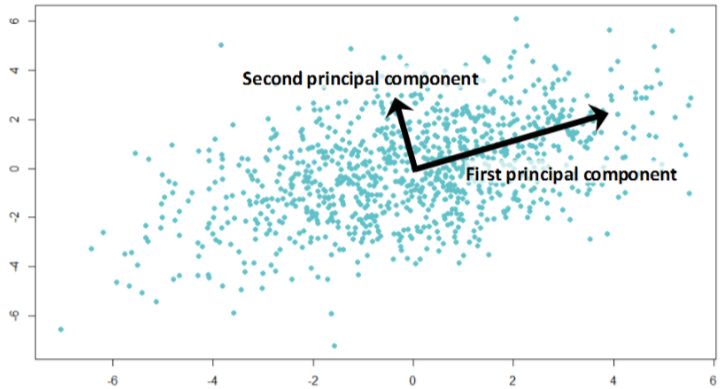

In [129]:
#If the two components are uncorrelated, their directions should be orthogonal (image below). 
#This image is based on a simulated data with 2 predictors. Notice the direction of the components, 
#as expected they are orthogonal. This suggests the correlation b/w these components in zero.

document_name = "PCA_2.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location)  

All succeeding principal component follows a similar concept i.e. they capture the remaining variation without being correlated with the previous component. In general, for n × p dimensional data, min(n-1, p) principal component can be constructed.

In [130]:
#To carry out a principal component analysis (PCA) on a multivariate data set, the first step is often to standardise
#the variables under study using the “scale()” function (see above). This is necessary if the input variables have
#very different variances
prin_comp_PD <- prcomp(X_train_PD, scale. = T)
prin_comp_AR <- prcomp(X_train_AR, scale. = T) 

In [131]:
#Let’s look at first 4 principal components and first 5 rows. (it would be equivalent for X_train_AR.pca (same results though))
prin_comp_PD$rotation[1:10,1:4]

,PC1,PC2,PC3,PC4
pre_167_BBUSD6M,-0.170958791,-0.05381461,-0.01872900,-0.17141433
pre_173_FRTBS3M,-0.147724454,-0.11979444,0.05600671,-0.13131203
pre_278_ICCHF30,-0.180423932,-0.01060881,0.06401908,0.10738920
pre_279_Spread_Corporates_AAA_1.3,-0.090916359,0.17504608,-0.08359415,-0.04295332
pre_281_Spread_Corporates_A_1.3_,-0.014311137,0.22611179,-0.06440777,-0.14564564
pre_283_Spread_Corporates_AAA_3.5,-0.006581508,0.14390610,-0.15557496,-0.16330284
pre_291_Spread_Corporates_AAA_7.10,-0.047081607,0.19456134,-0.06950488,-0.09023502
pre_315_IBEFSUB.RI.,0.116878322,-0.17323167,0.02168852,0.09914488
pre_321_USECBSP,-0.122147066,-0.07720514,0.09155707,0.12949774
pre_322_JPECBSP,-0.173553586,-0.04056829,0.08749139,0.04215959


In [132]:
#This gives us the standard deviation of each component, and the proportion of variance explained by each component.
#The cumulative Proportion tells us that the first 10 PC explain > 95% of all variance
summary(prin_comp_PD)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     5.1719 3.8867 3.2834 1.69961 1.60080 1.42694 1.31373
Proportion of Variance 0.3821 0.2158 0.1540 0.04127 0.03661 0.02909 0.02466
Cumulative Proportion  0.3821 0.5979 0.7519 0.79320 0.82981 0.85890 0.88355
                           PC8    PC9    PC10    PC11    PC12   PC13    PC14
Standard deviation     1.12159 1.0483 0.99069 0.93284 0.78304 0.6951 0.65311
Proportion of Variance 0.01797 0.0157 0.01402 0.01243 0.00876 0.0069 0.00609
Cumulative Proportion  0.90152 0.9172 0.93125 0.94368 0.95244 0.9593 0.96543
                          PC15    PC16    PC17    PC18    PC19   PC20    PC21
Standard deviation     0.58967 0.54178 0.52091 0.45422 0.38921 0.3745 0.36408
Proportion of Variance 0.00497 0.00419 0.00388 0.00295 0.00216 0.0020 0.00189
Cumulative Proportion  0.97040 0.97459 0.97847 0.98142 0.98358 0.9856 0.98748
                          PC22   PC23    PC24    P

### Deciding on How Many Principal Components to Retain


- We aim to find the components which explain the maximum variance. 


- This is because, we want to retain as much information as possible using these components. 


- So, higher is the explained variance, higher will be the information contained in those components.

In [133]:
#Using Kaiser’s criterion, we would retain 

cat("Number of principles components have variance greater than 1:", length(((prin_comp_PD$sdev)^2)[(prin_comp_PD$sdev)^2>1]))

Number of principles components have variance greater than 1: 9

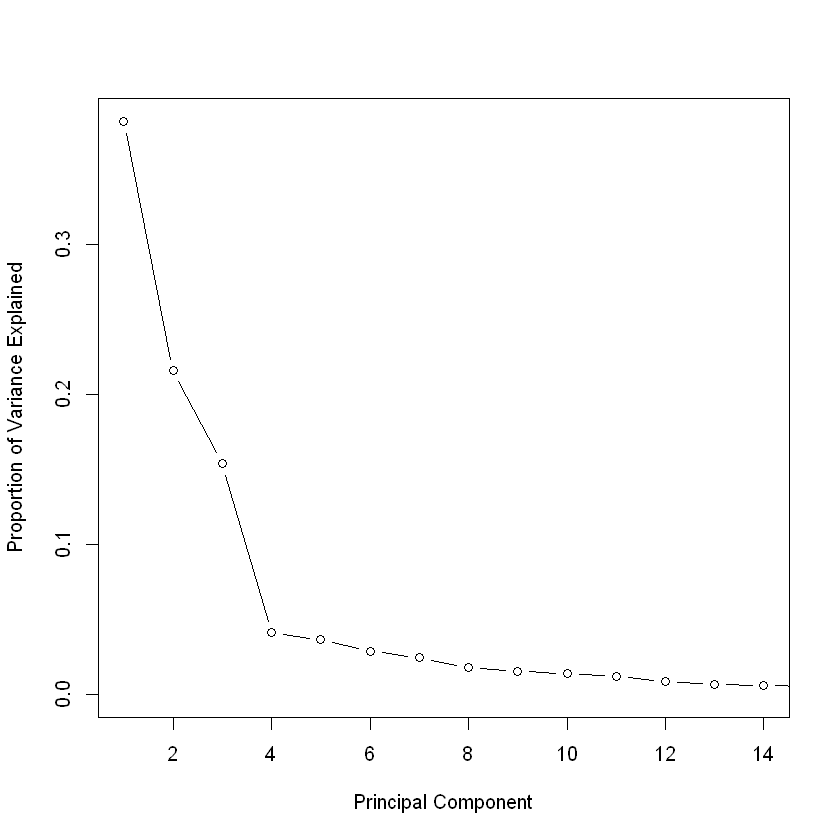

In [134]:
##Using Scree Plot:
#To compute the proportion of variance explained by each component, we simply divide the variance by sum of total variance. 

#compute variance
pr_var = (prin_comp_PD$sdev)^2
number_of_pcs_greater_1 = length(pr_var[pr_var>1])
prop_varex <- pr_var/sum(pr_var)

#proportion of variance explained
plot(prop_varex, xlab = "Principal Component",
             ylab = "Proportion of Variance Explained",
             type = "b", xlim = c(1, ceiling(1.5*number_of_pcs_greater_1)))

### Conclusion 1

- The most obvious change in slope in the scree plot occurs at component where the "elbow" of the screeplot is.


- Therefore, it could be argued based on the basis of the scree plot that the first components up until then could be retained

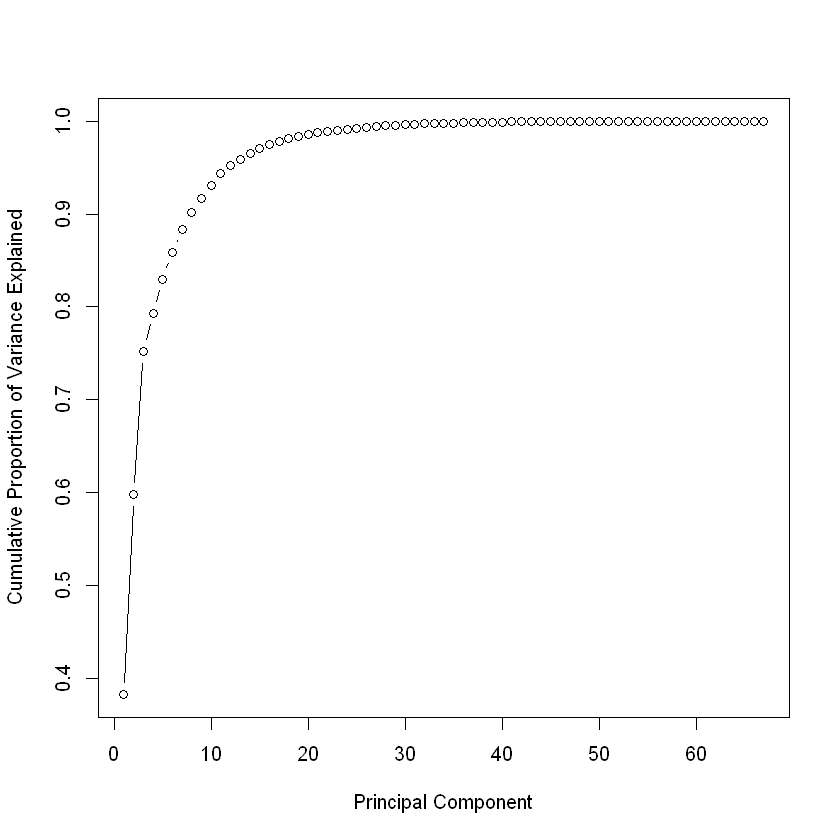

In [135]:
#cumulative scree plot
plot(cumsum(prop_varex), xlab = "Principal Component",
              ylab = "Cumulative Proportion of Variance Explained",
              type = "b")

### Conclusion 2

- This plot shows that the more components the more variance explained one can retain. 


- Already with a few principle components you reach a quite high variance


- At some point the marginal increase diminishes and you won't gain much more benefit by taking on another principle component


- Usually one aims to take as many PCs as to reach >90% of variance explained



## Now let's retain our Principal Components

I would argue it would be best to take a conservative approach and use the Kaiser Kriterion

In [136]:
#Here we take the selected principle components
X_train_PD.pca = prin_comp_PD$x[,1:number_of_pcs_greater_1]
X_train_AR.pca = prin_comp_AR$x[,1:number_of_pcs_greater_1]

head(X_train_AR.pca)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
6.240527,-2.516078,0.6958930,0.7825557,-1.690106,1.9974265,-1.8528636,2.2855759,-0.6482421
5.868896,-2.259443,-0.1296892,1.0288471,-2.085210,1.4993901,-0.7375207,1.7593814,-0.5667149
5.995389,-2.554876,1.8686719,-0.3804498,-1.662066,1.1527382,0.3013746,2.0298889,-1.1378663
6.160464,-2.401090,0.4081953,-1.9605097,-2.172545,-0.5854451,1.3566794,1.8955017,-0.5486514
6.285139,-2.367987,-0.7498592,-1.3923059,-2.385084,-0.4452386,1.0664689,1.5738236,-0.4907409
6.216379,-1.989727,-1.8017718,-0.5292520,-2.947452,0.2807910,1.4705682,0.7066357,0.6047583


In [138]:
#Let's run a quick pairwise correlation check to confirm that there should be none!

mosthighlycorrelated <- function(mydataframe,numtoreport)
{
# find the correlations
cormatrix <- cor(mydataframe)
# set the correlations on the diagonal or lower triangle to zero,
# so they will not be reported as the highest ones:
diag(cormatrix) <- 0
cormatrix[lower.tri(cormatrix)] <- 0
# flatten the matrix into a dataframe for easy sorting
fm <- as.data.frame(as.table(cormatrix))
# assign human-friendly names
names(fm) <- c("First.Variable", "Second.Variable","Correlation")
fm$Correlation = abs(fm$Correlation)
# sort and print the top n correlations
head(fm[order(abs(fm$Correlation),decreasing=T),],n=numtoreport)
}
mosthighlycorrelated(X_train_PD.pca, 5)

,First.Variable,Second.Variable,Correlation
30,PC3,PC4,2.347961e-15
69,PC6,PC8,1.437815e-15
46,PC1,PC6,1.394077e-15
40,PC4,PC5,1.230698e-15
37,PC1,PC5,9.331833e-16


#### Also visually we can confirm that by design there are no correlations among the features (as expected with PCs!)

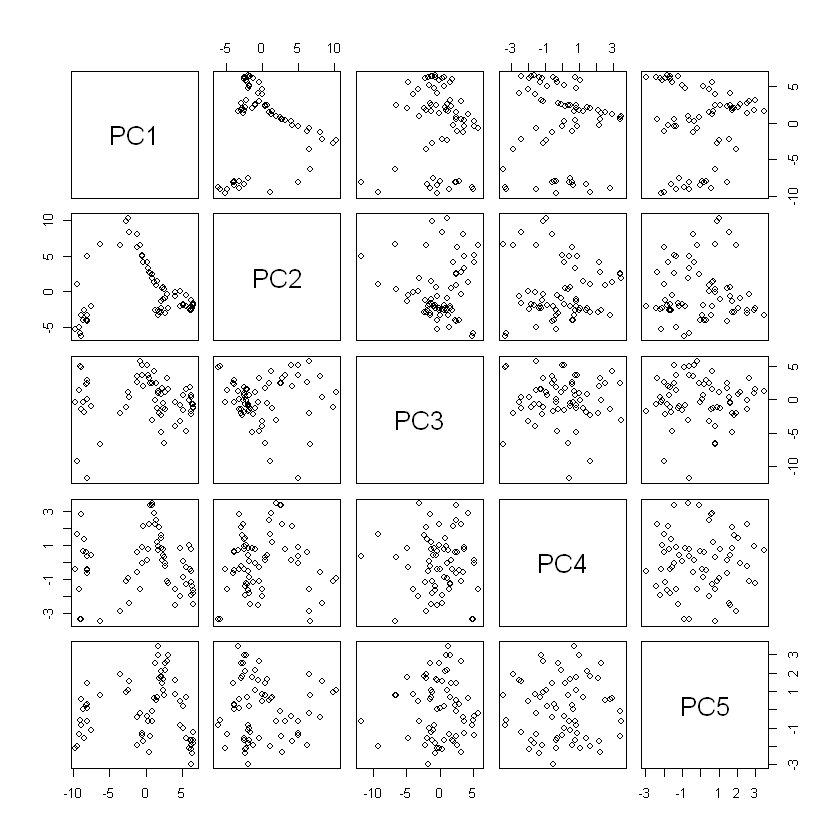

In [140]:
pairs(X_train_PD.pca[,1:5])

In [59]:
#This completes the steps to implement PCA on train data

### Predictive Modeling with PCA Components


After we’ve calculated the principal components on training set, let’s now understand the process of predicting on test data using these components. The process is simple. Just like we’ve obtained PCA components on training set, we’ll get another bunch of components on testing set. Finally, we train the model.


__But, few important points to understand:__

We should not combine the train and test set to obtain PCA components of whole data at once. Because, this would violate the entire assumption of generalization since test data would get ‘leaked’ into the training set. In other words, the test data set would no longer remain ‘unseen’. Eventually, this will hammer down the generalization capability of the model.
We should not perform PCA on test and train data sets separately. Because, the resultant vectors from train and test PCAs will have different directions ( due to unequal variance). Due to this, we’ll end up comparing data registered on different axes. Therefore, the resulting vectors from train and test data should have same axes.
So, what should we do?

In [141]:
head(X_test_PD)

pre_167_BBUSD6M,pre_173_FRTBS3M,pre_278_ICCHF30,pre_279_Spread_Corporates_AAA_1.3,pre_281_Spread_Corporates_A_1.3_,pre_283_Spread_Corporates_AAA_3.5,pre_291_Spread_Corporates_AAA_7.10,pre_315_IBEFSUB.RI.,pre_321_USECBSP,pre_322_JPECBSP,...,pre_622_EU_IND_PROD_VOLA,pre_623_D_LABPROD_USD,pre_646_EUR_Gross_Invest,pre_647_GER_Gross_Invest,pre_648_CBOEVIX,pre_651_BBJPY1W,pre_654_BBJPY6M,pre_658_TRJP30T,pre_660_TRJP2YT,pre_662_ESGBOND.
0.92415,0.26,0.072,0.003268333,0.004268333,0.002011667,0.00078625,239.491,1.1102,114.05,...,104.6,103.1000,104.1,104.4000,14.77,-0.06200,-0.00950,0.142,-0.298,0.0148
0.99310,0.34,0.345,0.002835000,0.004225000,0.002211667,0.00324250,241.690,1.1154,123.83,...,103.9,103.0444,103.5,105.1667,14.20,-0.02557,-0.00507,0.299,-0.236,0.0157
0.90415,0.22,0.382,0.002636000,0.004356000,0.002168333,0.00215500,241.315,1.1403,122.34,...,105.3,102.9889,102.9,105.9333,14.68,-0.03414,0.00586,0.346,-0.233,0.0153
0.89970,0.21,0.367,0.002738333,0.004838333,0.002488333,0.00312750,238.453,1.1385,127.90,...,103.8,102.9333,102.3,106.7000,13.10,-0.07529,0.02350,0.542,-0.207,0.0154
0.88590,0.33,0.287,0.003351667,0.006161667,0.003050000,0.00359875,233.441,1.0888,123.14,...,104.4,102.6000,102.5,106.3000,17.70,-0.05300,-0.00629,0.860,-0.232,0.0172
0.86025,0.32,0.560,0.002868333,0.005218333,0.002920000,0.00199650,235.340,1.0920,132.25,...,105.8,102.2667,102.7,105.9000,19.98,0.02743,0.06143,1.076,-0.060,0.0172


In [142]:
#transform test into PCA
X_test_PD.pca <- predict(prin_comp_PD, newdata = X_test_PD)
X_test_AR.pca <- predict(prin_comp_AR, newdata = X_test_AR)

#select the first components according to the Kairser Criterion form your train set analysis:
X_test_PD.pca = X_test_PD.pca[,1:number_of_pcs_greater_1]
X_test_AR.pca = X_test_AR.pca[,1:number_of_pcs_greater_1]

In [143]:
head(X_test_PD.pca)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
8.505869,-2.439925,-2.47338722,-2.777689,-2.583475,-2.1810970,-4.106991,2.634086,2.230768
7.914888,-2.591748,-1.26988972,-2.273720,-3.443731,-0.8819323,-3.735359,1.856941,3.937357
7.778322,-2.563909,-0.97987236,-1.684934,-3.012414,-0.1654567,-3.810705,1.964042,3.620767
7.488215,-2.183089,-0.09415793,-1.578318,-2.527442,0.8499258,-3.749932,2.481010,3.784939
7.011348,-1.513394,-2.56635644,-1.367651,-2.966908,-0.2649991,-4.463867,3.167791,3.779076
6.150838,-1.515713,-3.29563395,-1.517989,-3.544864,-1.2499789,-4.773251,2.647615,3.468155


### Conclusion

What we achieved was that we transformed our dataset well enough, so that we can proceed to the final step of our forecasting approach.

In [144]:
#Merge y_train and X_train_PD.pca as well as y_test and X_test_PD.pca together
ABT_train_PD = data.frame(y_train_PD, X_train_PD.pca)
ABT_train_AR = data.frame(y_train_AR, X_train_AR.pca)
cat("Number of columns in ABT_train_PD:", ncol(ABT_train_PD),"\n")
cat("Number of rows in ABT_train_PD:", nrow(ABT_train_PD),"\n")
cat("Number of columns in ABT_train_AR:", ncol(ABT_train_AR),"\n")
cat("Number of rows in ABT_train_AR:", nrow(ABT_train_AR), "\n")


ABT_test_PD = data.frame(y_test_PD, X_test_PD.pca)
ABT_test_AR = data.frame(y_test_AR, X_test_AR.pca)
cat("Number of columns in ABT_test_PD:", ncol(ABT_test_PD),"\n")
cat("Number of rows in ABT_test_PD:", nrow(ABT_test_PD), "\n")
cat("Number of columns in ABT_test_AR:", ncol(ABT_test_AR),"\n")
cat("Number of rows in ABT_test_AR:", nrow(ABT_test_AR))

Number of columns in ABT_train_PD: 10 
Number of rows in ABT_train_PD: 67 
Number of columns in ABT_train_AR: 10 
Number of rows in ABT_train_AR: 67 
Number of columns in ABT_test_PD: 10 
Number of rows in ABT_test_PD: 39 
Number of columns in ABT_test_AR: 10 
Number of rows in ABT_test_AR: 39

In [145]:
#Save file
write.csv(ABT_train_PD,"ABT_train_PD",row.names=FALSE)
write.csv(ABT_train_AR,"ABT_train_AR",row.names=FALSE)
write.csv(ABT_test_PD,"ABT_train_PD",row.names=FALSE)
write.csv(ABT_test_AR,"ABT_train_PD",row.names=FALSE)

In [146]:
#END


Recursive feature selection

Outer resampling method: Cross-Validated (4 fold) 

Resampling performance over subset size:

 Variables    RMSE Rsquared     MAE   RMSESD RsquaredSD    MAESD Selected
         1 0.13273   0.5936 0.09232 0.028057    0.14563 0.017174         
         2 0.08025   0.8318 0.05252 0.023794    0.07248 0.009255         
         3 0.06773   0.8829 0.04624 0.019738    0.07770 0.008040         
         4 0.06768   0.8919 0.04786 0.024213    0.07888 0.012322         
         5 0.07095   0.9017 0.05002 0.012635    0.06812 0.005964         
         6 0.06163   0.9231 0.04129 0.011833    0.03391 0.004344         
         7 0.06116   0.9303 0.04278 0.009652    0.03109 0.004061        *
         8 0.06481   0.9303 0.04512 0.009991    0.02177 0.004718         
         9 0.06361   0.9271 0.04406 0.013011    0.02716 0.006055         
        10 0.06170   0.9357 0.04354 0.014432    0.02819 0.006799         
        11 0.06315   0.9358 0.04570 0.010439    0.02545 0.0059

[1] "PC2"  "PC4"  "PC3"  "PC1"  "PC6"  "PC12" "PC10"

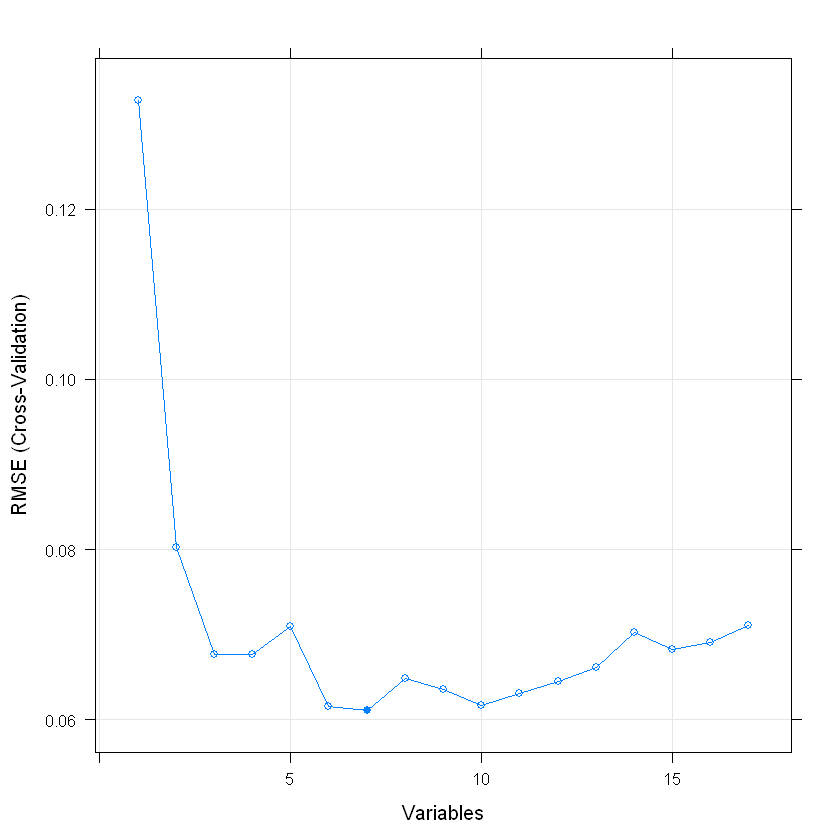

In [15]:
set.seed(1)
control <- rfeControl(functions=rfFuncs, method="cv", number=4)
# run the RFE algorithm
results <- rfe(temp[,-1], temp[,1], sizes=c(1:106), rfeControl=control)
# summarize the results
print(results)
# list the chosen features
predictors(results)
# plot the results
plot(results, type=c("g", "o"))

### Small check what significance the linear model receives with selected PCs

,coef.fit.,X2.5..,X97.5..
(Intercept),0.0643247606,5.970599e-02,0.068943534
PC1,0.0040545357,3.766999e-03,0.004342073
PC2,0.0096362544,9.134706e-03,0.010137803
PC3,0.0100892644,9.388230e-03,0.010790298
PC4,0.0254504986,2.455905e-02,0.026341948
PC5,0.0006606744,-7.916987e-04,0.002113047
PC6,0.0141586450,1.260118e-02,0.015716110
PC7,0.0016247680,-9.230259e-05,0.003341839
PC8,0.0046994853,2.583270e-03,0.006815701
PC9,-0.0062194360,-8.757317e-03,-0.003681555



Call:
lm(formula = temp[, 1] ~ ., data = temp[, 2:18])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.051435 -0.015611 -0.001937  0.015751  0.075800 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0643248  0.0023242  27.677  < 2e-16 ***
PC1          0.0040545  0.0001447  28.023  < 2e-16 ***
PC2          0.0096363  0.0002524  38.182  < 2e-16 ***
PC3          0.0100893  0.0003528  28.601  < 2e-16 ***
PC4          0.0254505  0.0004486  56.736  < 2e-16 ***
PC5          0.0006607  0.0007308   0.904  0.36846    
PC6          0.0141586  0.0007837  18.066  < 2e-16 ***
PC7          0.0016248  0.0008640   1.880  0.06335 .  
PC8          0.0046995  0.0010649   4.413 2.88e-05 ***
PC9         -0.0062194  0.0012771  -4.870 4.88e-06 ***
PC10         0.0015417  0.0014105   1.093  0.27735    
PC11        -0.0067079  0.0014790  -4.536 1.81e-05 ***
PC12        -0.0151721  0.0015866  -9.562 2.85e-15 ***
PC13         0.0118446  0.0017363   6.822 1.0

temp...1.,fitted.fit.,resid.fit.
-0.06627312,-0.05606308,-1.021004e-02
-0.05826701,-0.05831372,4.671754e-05
-0.05026089,-0.06644268,1.618179e-02
-0.04225477,-0.06504274,2.278797e-02


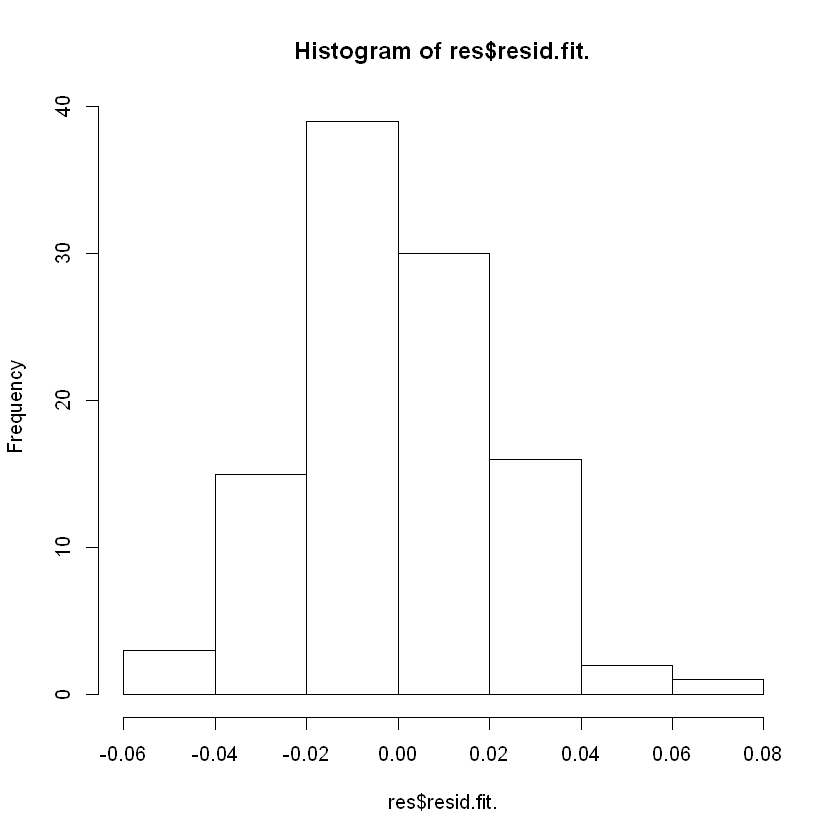

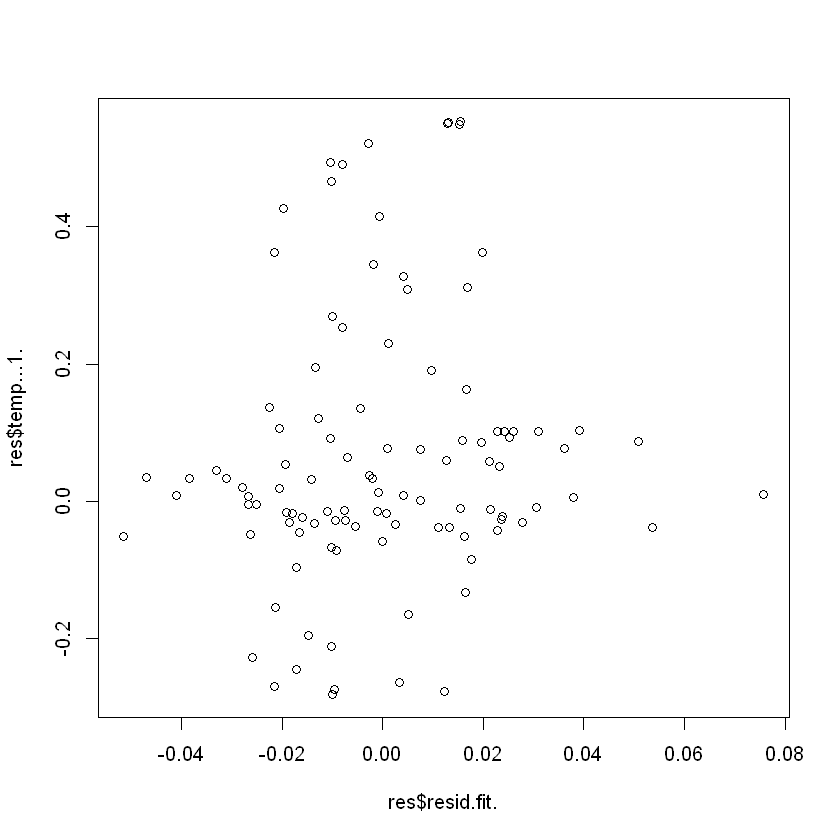

In [16]:
fit=lm(temp[,1] ~ . , data = temp[,2:18])
data.frame(coef(fit),confint(fit))
summary(fit)
res=data.frame(temp[,1],fitted(fit),resid(fit));head(res,4)
hist(res$resid.fit.)
plot(res$resid.fit.,res$temp...1.)

1. The RFE algorithm indicated PC1,2,3,4,6,10,12 to be significant
2. The linear model indicated PC1,2,3,4,6,8,9,11,12,13,15 to be strongly significant (adj. R^2 >98%)

### Another way to look at which PCs to take is to compute the posterior probability

In [ ]:
temp = cbind(ABT_dependent, data_final)
fit1 <- modelSelection(temp[,1],temp[,-1])
head(postProb(fit1))
#Here we see that the first 5 principle components deliver the best posterior probability. So we can exclude the rest

In [20]:
# Decide if a variable is important or not using Boruta
boruta_output <- Boruta(temp[,1] ~ ., data=na.omit(temp[,-1]), doTrace=2)  # perform Boruta search
boruta_signif <- names(boruta_output$finalDecision[boruta_output$finalDecision %in% c("Confirmed", "Tentative")])  # collect Confirmed and Tentative variables


 1. run of importance source...
 2. run of importance source...
 3. run of importance source...
 4. run of importance source...
 5. run of importance source...
 6. run of importance source...
 7. run of importance source...
 8. run of importance source...
 9. run of importance source...
 10. run of importance source...
 11. run of importance source...
After 11 iterations, +2 secs: 
 confirmed 9 attributes: PC1, PC10, PC12, PC2, PC3 and 4 more;
 rejected 1 attribute: PC11;
 still have 7 attributes left.

 12. run of importance source...
 13. run of importance source...
 14. run of importance source...
 15. run of importance source...
After 15 iterations, +2.6 secs: 
 rejected 2 attributes: PC14, PC16;
 still have 5 attributes left.

 16. run of importance source...
 17. run of importance source...
 18. run of importance source...
 19. run of importance source...
After 19 iterations, +3.1 secs: 
 confirmed 1 attribute: PC8;
 still have 4 attributes left.

 20. run of importance source...

 [1] "PC1"  "PC2"  "PC3"  "PC4"  "PC5"  "PC6"  "PC7"  "PC8"  "PC10" "PC12"
[11] "PC13" "PC15"


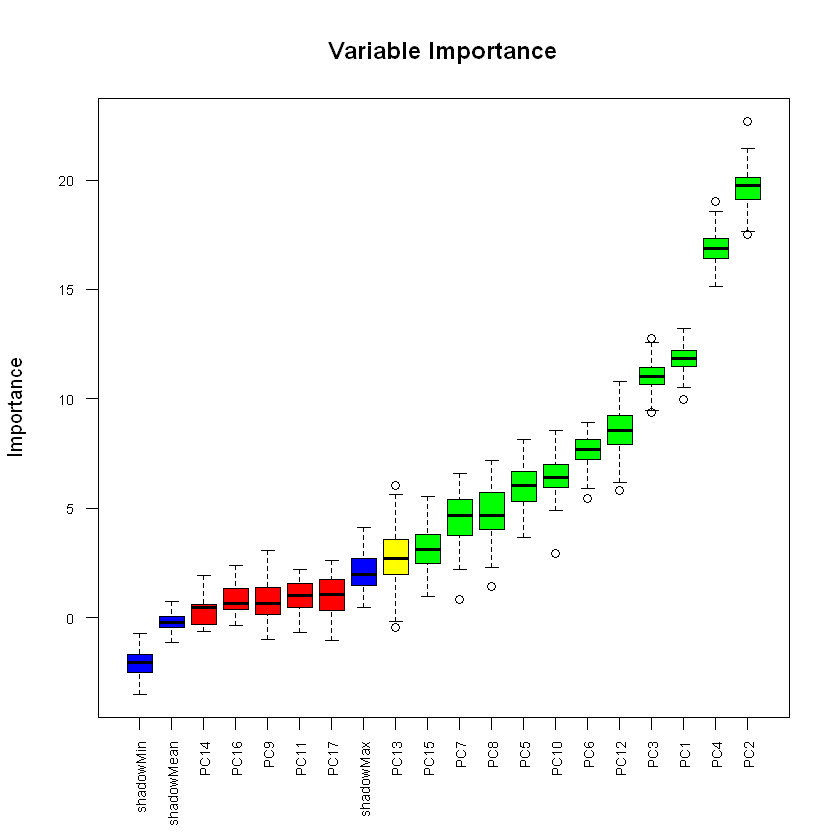

In [21]:
print(boruta_signif)  # significant variables
plot(boruta_output, cex.axis=.7, las=2, xlab="", main="Variable Importance")  # plot variable importance
#PC8,9,10,11 rejected

### Finally the results of the Boruta algorithm seem to indicate that almost all PC are significant except a chosen few (see results above)

In [22]:
#Now we make a decision and select the PCs that we seem appropriate
data_final = data_final %>%
select("PC1",  "PC2",  "PC3",  "PC4",  "PC5",  "PC6",  "PC7",  "PC8",  "PC10", "PC12","PC13", "PC15")


In [23]:
preprocessed_data = cbind(ABT_clean$Date,ABT_dependent,data_final)
names(preprocessed_data) = c(names(ABT_clean)[1],names(ABT_dependent), names(data_final) )

In [24]:
head(preprocessed_data)

Date,pre_44_CRPh_delta_LogitPD,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC10,PC12,PC13,PC15
2016-06-30,-0.06627312,-25.32335,-2.714677,7.662062,-2.0629316,2.492621,-2.159775,2.6243371,-3.862366,0.5927015,0.7480910,-0.10635479,-0.118355432
2016-05-31,-0.05826701,-24.20842,-4.234424,8.512948,-0.8495366,2.187867,-2.336764,1.2590291,-4.383409,0.1877023,0.5002253,-0.63437313,0.819959361
2016-04-30,-0.05026089,-23.46424,-4.035924,7.439302,-1.0105495,2.139154,-2.288762,0.8421565,-4.530246,0.1747278,0.3675362,-0.85803219,0.532513352
2016-03-31,-0.04225477,-23.64910,-3.741338,8.435179,-1.1239752,2.392398,-2.652856,-0.1959141,-4.433293,0.8908032,-0.1331091,-1.72896836,0.110740205
2016-02-29,-0.03731459,-23.21657,-2.678558,9.825805,-3.1091132,3.549999,-1.542833,1.7694982,-3.443088,1.6628592,0.5658642,0.06547134,0.003059274
2016-01-31,-0.03237442,-22.21431,-4.028633,10.640222,-2.6929828,3.716776,-0.361039,1.9514320,-3.012097,1.9058893,1.6595474,2.72360546,0.990445839


In [26]:
#Save file
write.csv(preprocessed_data,"preprocessed_data.csv",row.names=FALSE)

In [ ]:
#END

# Try out Prophet from FB (move to 2_models once done)

ds,y
2016-06-30,-0.06627312
2016-05-31,-0.05826701
2016-04-30,-0.05026089
2016-03-31,-0.04225477
2016-02-29,-0.03731459
2016-01-31,-0.03237442


       ds                   y           
 Min.   :2007-09-30   Min.   :-0.28111  
 1st Qu.:2009-12-07   1st Qu.:-0.03312  
 Median :2012-02-14   Median : 0.01610  
 Mean   :2012-02-14   Mean   : 0.06432  
 3rd Qu.:2014-04-22   3rd Qu.: 0.10342  
 Max.   :2016-06-30   Max.   : 0.55352  

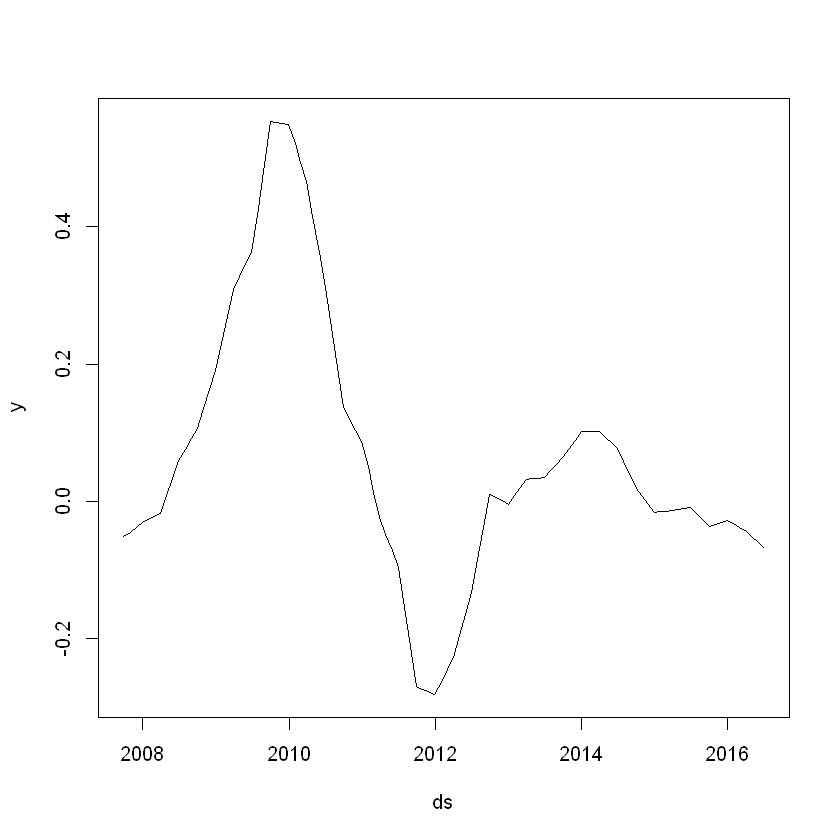

In [27]:
df = ABT %>%
select(contains("Date"), contains("pre_44_CRPh_delta_LogitPD"))%>%
na.omit()

colnames(df) <- c("ds", "y")
head(df)

summary(df)
plot(y ~ ds, df, type = "l")

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.
Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -10.9789
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


,ds,yhat,yhat_lower,yhat_upper
113,2016-07-07,-0.05378026,-0.2817535,0.1724534
114,2016-07-08,-0.05315032,-0.2824235,0.1661699
115,2016-07-09,-0.05252889,-0.2997797,0.1719068
116,2016-07-10,-0.05193976,-0.2892113,0.1667699
117,2016-07-11,-0.05140354,-0.2990659,0.1670073
118,2016-07-12,-0.05093704,-0.2785155,0.1873035


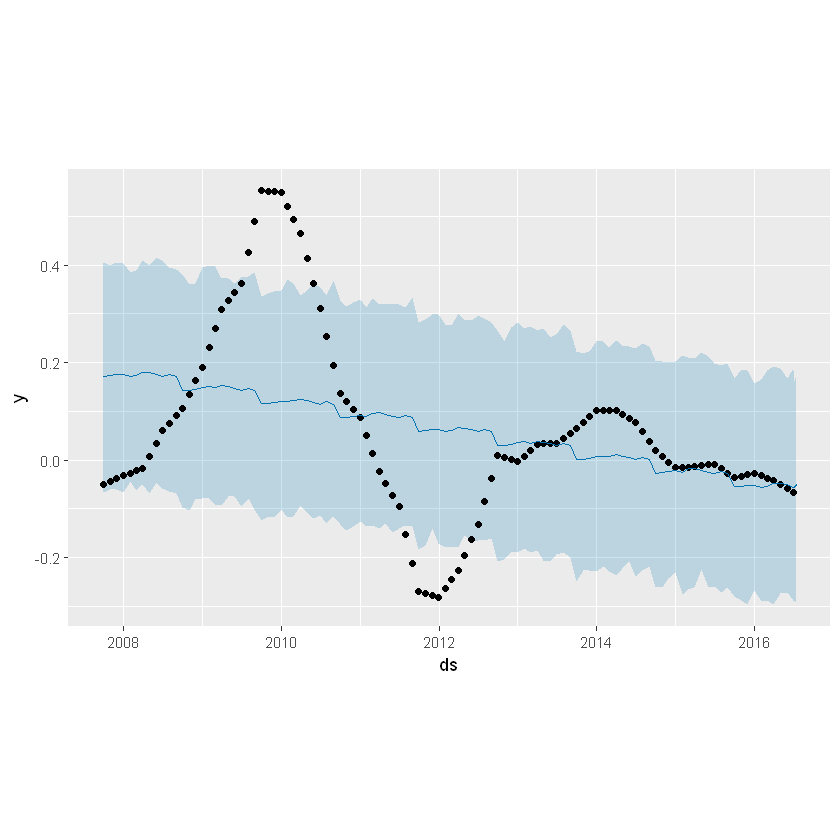

In [30]:
m <- prophet(df)
future <- make_future_dataframe(m, periods = 12)
forecast <- predict(m, future)

plot(m, forecast)
tail(forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')])

,ds,trend,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat_lower,yhat_upper,trend_lower,trend_upper,yhat
113,2016-07-07,-0.06267813,0.008897870,0.008897870,0.008897870,0.008897870,0.008897870,0.008897870,0.008897870,0.008897870,0.008897870,-0.2817535,0.1724534,-0.06267813,-0.06267813,-0.05378026
114,2016-07-08,-0.06275618,0.009605861,0.009605861,0.009605861,0.009605861,0.009605861,0.009605861,0.009605861,0.009605861,0.009605861,-0.2824235,0.1661699,-0.06275618,-0.06275618,-0.05315032
115,2016-07-09,-0.06283423,0.010305348,0.010305348,0.010305348,0.010305348,0.010305348,0.010305348,0.010305348,0.010305348,0.010305348,-0.2997797,0.1719068,-0.06283423,-0.06283423,-0.05252889
116,2016-07-10,-0.06291229,0.010972520,0.010972520,0.010972520,0.010972520,0.010972520,0.010972520,0.010972520,0.010972520,0.010972520,-0.2892113,0.1667699,-0.06291229,-0.06291229,-0.05193976
117,2016-07-11,-0.06299034,0.011586792,0.011586792,0.011586792,0.011586792,0.011586792,0.011586792,0.011586792,0.011586792,0.011586792,-0.2990659,0.1670073,-0.06299034,-0.06299034,-0.05140354
118,2016-07-12,-0.06306839,0.012131352,0.012131352,0.012131352,0.012131352,0.012131352,0.012131352,0.012131352,0.012131352,0.012131352,-0.2785155,0.1873035,-0.06306839,-0.06306839,-0.05093704


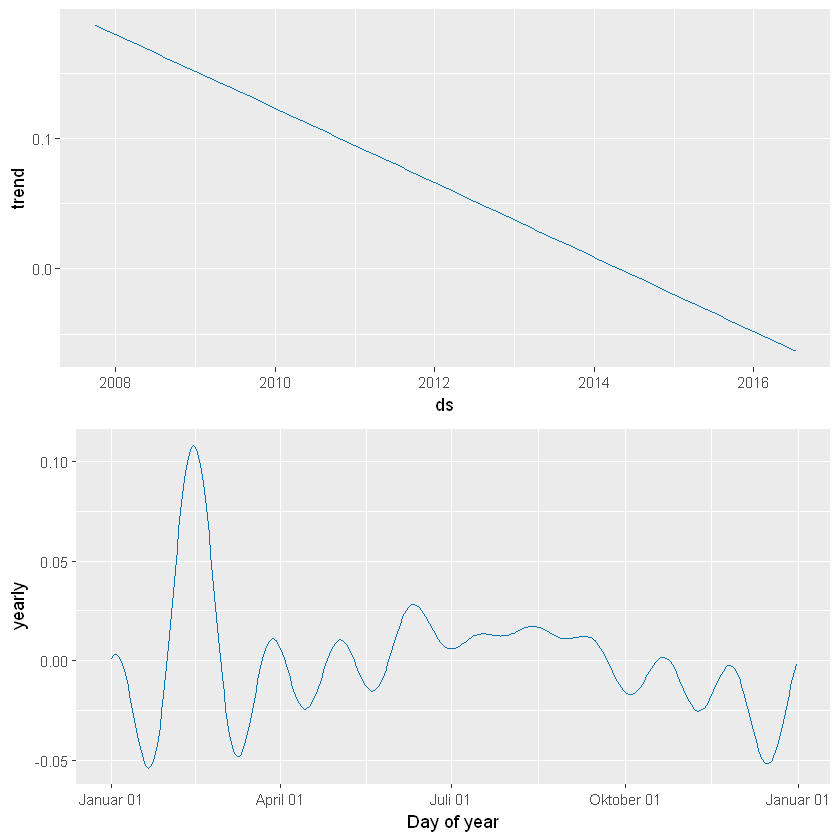

In [31]:
tail(forecast)
prophet_plot_components(m, forecast)

## Bonus: Check time series for dependent variable and features

#### Time series could be decomposed into three components. These three components are the trend0cycle, the seasonal component and random component, which are denoted as T_t, S_t and R_t respectively, with the original time series denoted by Yt_. We could write the time series Y_t as a functon of these components:

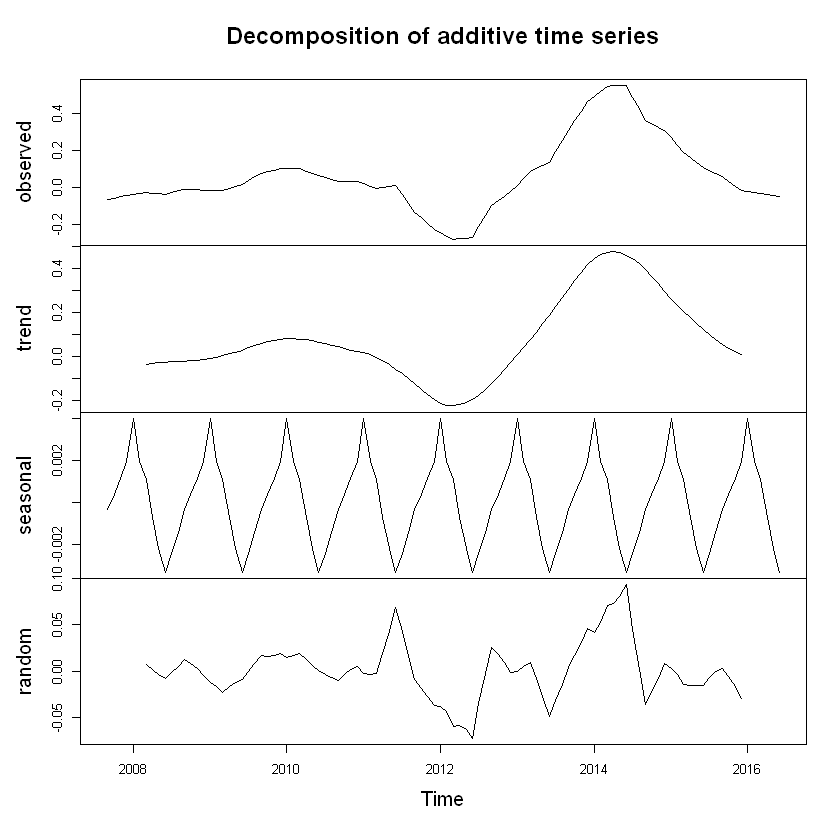

In [39]:
ABT_dependent_ts= ts(ABT_dependent,frequency = 12,start = c(2007,9) )
plot(decompose(ABT_dependent_ts))

In [54]:
#acf(ABT_dependent_ts)
#acf(preprocessed_data[,2])
a = ABT_dependent
sqrt(mean((diff(a$pre_44_CRPh_delta_LogitPD))^2))

[1] 0.02664821

## Cross Correlation!

#### Time series could be decomposed into three components. These three components are the trend cycle, the seasonal component and random component, which are denoted as T_t, S_t and R_t respectively, with the original time series denoted by Y_t. We could write the time series Y_t as a functon of these components:

, , 1

            [,1]
 [1,] 0.49981612
 [2,] 0.45557767
 [3,] 0.40674369
 [4,] 0.35334483
 [5,] 0.30339568
 [6,] 0.25873725
 [7,] 0.22066420
 [8,] 0.19006417
 [9,] 0.15768480
[10,] 0.13168866
[11,] 0.11355092
[12,] 0.09844641
[13,] 0.08914320
[14,] 0.08107039
[15,] 0.08103518


Autocorrelations of series 'X', by lag

   -7    -6    -5    -4    -3    -2    -1     0     1     2     3     4     5 
0.500 0.456 0.407 0.353 0.303 0.259 0.221 0.190 0.158 0.132 0.114 0.098 0.089 
    6     7 
0.081 0.081 

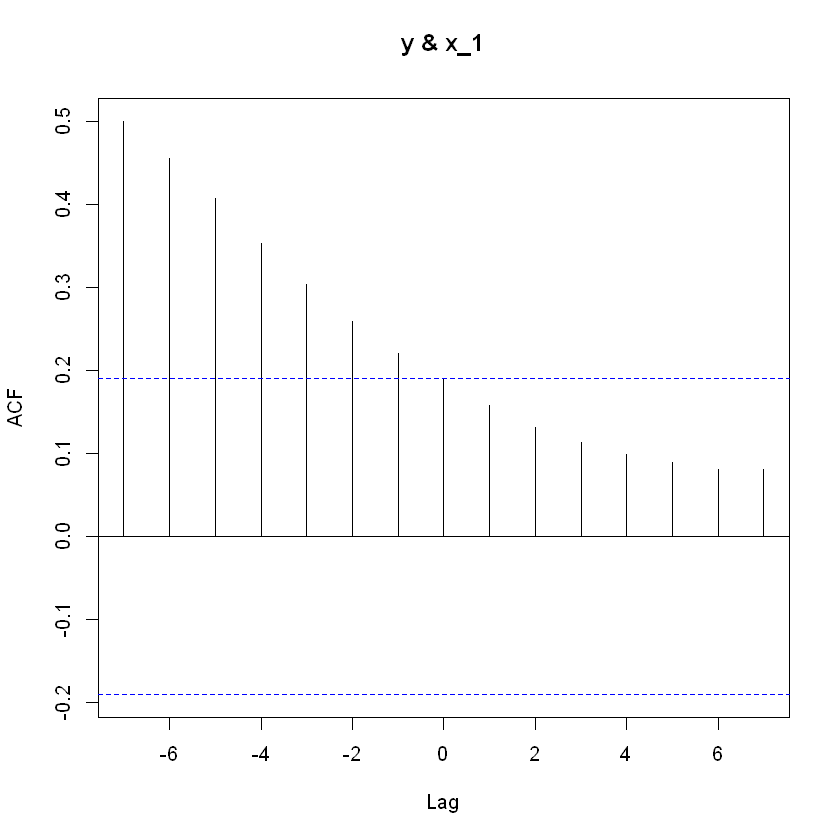

In [64]:
# cross time series correlation function dependent vs variable1
#y = ts(ABT_dependent,frequency = 4,start = c(2006,3) )
#x_1 = ts(ABT_features$pre_155_EU_KEY_RATE,frequency = 4,start = c(2006,3) )
y=ts(ABT_dependent$pre_44_CRPh_delta_LogitPD)
x_1 = ts(ABT_features[,120])
ccfvalues = ccf(y, x_1, lag.max = 7)
#tail(sort(ccfvalues$acf, decreasing = F),3)
abs(ccfvalues$acf)
ccfvalues

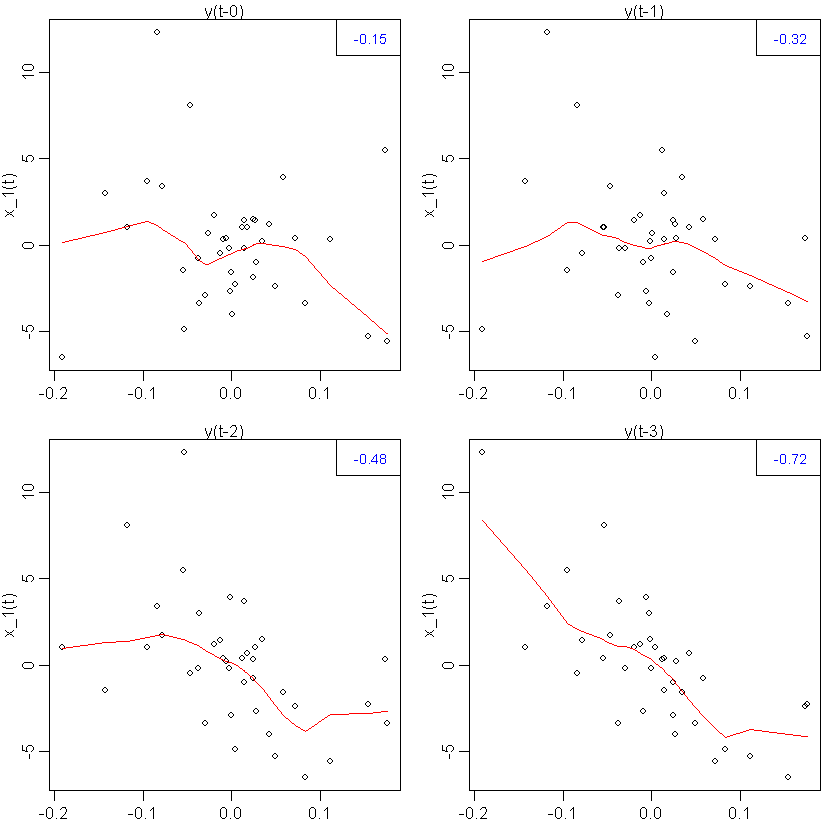

In [368]:
lag2.plot(y,x_1, 3)

In [36]:
x_1

Time Series:
Start = 1 
End = 36 
Frequency = 1 
 [1] 125.482 144.383 182.626 184.386 212.359 214.282 188.772 200.120 192.317
[10] 199.918 194.213 182.794 160.548 163.214 163.190 147.702 132.789 149.320
[19] 132.541 133.680 185.554 198.939 196.307 209.585 193.658 222.435 222.000
[28] 236.307 178.686 124.382 151.107 263.237 285.278 343.957 424.259 463.288

## Systematisch features auswählen und modellieren

In [59]:
y=ts(ABT_dependent$pre_44_CRPh_delta_LogitPD)

my_function = function(dependent_series, feature_series,i) {
    x_1 = ts(diff(feature_series[,i]))
    ccfvalues = ccf(diff(dependent_series), x_1, pl=FALSE, lag.max = 5)
    temp = max(abs(ccfvalues$acf))
    #temp2 = c(temp,i)
    print(temp)
#    return(c(temp,i))
}




In [60]:
max_cor = c()
for (i in 1:345){
    max_cor[i] = my_function(y,ABT_features,i)
}


[1] 0.3830736
[1] 0.3009212
[1] 0.3587735
[1] 0.4089432
[1] 0.3911616
[1] 0.3818053
[1] 0.374028
[1] 0.2606019
[1] 0.3168842
[1] 0.3272105
[1] 0.1979067
[1] 0.239764
[1] 0.2412581
[1] 0.1714946
[1] 0.175516
[1] 0.1691427
[1] 0.1611249
[1] 0.2451336
[1] 0.1968543
[1] 0.3233062
[1] 0.3470119
[1] 0.3642211
[1] 0.3620693
[1] 0.3538336
[1] 0.3463805
[1] 0.3490843
[1] 0.3453169
[1] 0.344309
[1] 0.3440949
[1] 0.3382844
[1] 0.3384297
[1] 0.3351709
[1] 0.3268183
[1] 0.322936
[1] 0.3070117
[1] 0.2986181
[1] 0.2883052
[1] 0.2794574
[1] 0.2448567
[1] 0.2216981
[1] 0.1911146
[1] 0.1661232
[1] 0.1460802
[1] 0.1316454
[1] 0.1174709
[1] 0.1074616
[1] 0.3348743
[1] 0.2863967
[1] 0.2443075
[1] 0.2074947
[1] 0.1767625
[1] 0.1539118
[1] 0.1359386
[1] 0.1227603
[1] 0.1120096
[1] 0.1025957
[1] 0.08870212
[1] 0.1111577
[1] 0.1303751
[1] 0.1390968
[1] 0.1400988
[1] 0.3097285
[1] 0.2755881
[1] 0.2375201
[1] 0.2021439
[1] 0.1731659
[1] 0.1524699
[1] 0.1337462
[1] 0.1204727
[1] 0.1093243
[1] 0.09915754
[1] 0.091

In [39]:
temp = head(sort(max_cor, decreasing = T),10)
temp
which(max_cor %in% temp[1:5])


[1] 0.6297911 0.6281309 0.6234347 0.6196937 0.6168299 0.6161919 0.6141532
 [8] 0.6111822 0.6058984 0.6055836

[1] 120 182 258 319 320

In [40]:
names(ABT_features)[326]

[1] "pre_494_S2SEB2E"

In [27]:
Bibliography
#https://media.readthedocs.org/pdf/little-book-of-r-for-multivariate-analysis/latest/little-book-of-r-for-multivariate-analysis.pdf

ERROR: Error in eval(expr, envir, enclos): Objekt 'Bibliography' nicht gefunden
